## These are plots formed after saving the data across subjects run in SWRanalysis.ipynb 

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1'

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


## Plot CA3 v. DG on same plot

CA1: 3211 recalls
Test 1 p-value: 0.8551984742479201
Test 2 p-value: 0.8407443735077846
Dentate gyrus: 2397 recalls
Test 1 p-value: 0.6640347671201461
Test 2 p-value: 0.9461553452498093


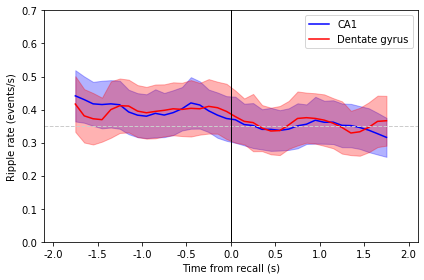

In [129]:
# load data from each

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 1 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'HPC'
# location_selected = 'ca1' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)

pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

for p,location_selected in enumerate(['ca1','dg']):
    
    if p==0:
        subplots(1,1,figsize=(6,4)); ax = plt.gca()
        color = (0,0,1)
        label = 'CA1'
        line_dist = 0.175
    else:
        color = (1,0,0)
        label = 'Dentate gyrus'
        line_dist = 0.15

    path_name = '/home1/john/SWR/figures/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'.p')            
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; CI_plot = dat['CI_plot']; num_trials = dat['num_trials'];
        bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']

    # make plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)

    # plot smoothed mean +/- CI
    if pad > 0:
        plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
        fill_between(xr[pad:-pad], PSTH[pad:-pad]-CI_plot[0,:], PSTH[pad:-pad]+CI_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')
    else:
        plot(xr,PSTH)
        fill_between(xr, PSTH-CI_plot[0,:], PSTH+CI_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')

    # plot bands of significance
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[line_dist,line_dist],'--',
             color=color,label='_nolegend_')
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
             color=color,label='_nolegend_')
    print(label+': '+str(num_trials)+' recalls')
    print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
    print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
ax.legend({'CA1','Dentate gyrus'})
tight_layout()
plt.show()
a=1;
a=1;

## Single data plots

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2ae2595a17d0>)

Entorhinal cortex: 1710 recalls
Test 1 p-value: 0.7449778124644933
Test 2 p-value: 0.08310803384052465


([<matplotlib.axis.XTick at 0x2ae25c78c150>,
 <a list of 9 Text xticklabel objects>)

Text(0.5, 0, 'Time from recall (s)')

Text(0, 0.5, 'Ripple rate (events/s)')

(0, 0.7)

(-2100, 2100)

Entorhinal cortex: 1710 recalls
Test 1 p-value: 0.7449778124644933
Test 2 p-value: 0.08310803384052465


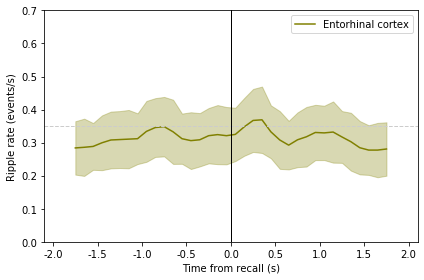

In [207]:
# load data from each

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 3 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'ENT' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
location_selected = '' #'ca1' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)

legend_name = 'Entorhinal cortex' #'Parahippocampal cortex' #'Entorhinal'
color = (0.5,0.5,0) # (0.5,0.5,0)
line_dist = 0.175

pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

subplots(1,1,figsize=(6,4)); ax2 = plt.gca()

path_name = '/home1/john/SWR/figures/'+subfolder
fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'.p')            
with open(fn,'rb') as f:
    dat = pickle.load(f)
    bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; CI_plot = dat['CI_plot']; num_trials = dat['num_trials'];
    bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']; ss = dat['session_name_array']

# make plot
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- CI
if pad > 0:
    plot(xr[pad:-pad],PSTH[pad:-pad],color=color);
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-CI_plot[0,:], PSTH[pad:-pad]+CI_plot[0,:],
                 color=color, alpha = 0.3, label='_nolegend_');
else:
    plot(xr,PSTH);
    fill_between(xr, PSTH-CI_plot[0,:], PSTH+CI_plot[0,:],
                 color=color, alpha = 0.3, label='_nolegend_');

# plot bands of significance
if bin_model1.pvalues[1] < 0.05:
    plot([first_end-stats_bin,first_end],[line_dist,line_dist],'--',
         color=color,label='_nolegend_');
if bin_model2.pvalues[1] < 0.05:
    plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
         color=color,label='_nolegend_');
print(legend_name+': '+str(num_trials)+' recalls')
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax2.set_ylim(0,ylim)
ax2.set_xlim(psth_start-100,psth_end+100)
plot([ax2.get_xlim()[0],ax2.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
plot([0,0],[ax2.get_ylim()[0],ax2.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
plt.legend({legend_name})
tight_layout()
print(legend_name+': '+str(num_trials)+' recalls')
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
a=1;
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

# Comparison plots for clustering

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


High clustering lists: 5572 recalls
Low clustering lists: 5992 recalls
Test 1 comparison p-value: 0.026720014977698506
Test 2 comparison p-value: 0.6526245031374507


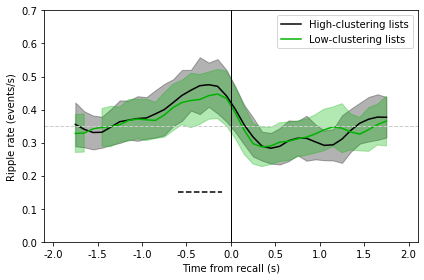

In [183]:
# load data from each

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 3 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'HPC'
# location_selected = 'ca1' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)

min_recalls = 4 # minimum recalls/list

pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

session_accum = np.array([])
subject_accum = copy(session_accum)
ripple_accum1 = copy(session_accum)
ripple_accum2 = copy(session_accum)
category = copy(session_accum)

for p,upper_label in enumerate(['upper','lower']):
    
    location_selected = ''
    if p==0:
        subplots(1,1,figsize=(6,4)); ax = plt.gca()
        color = (0,0,0)
        line_dist = 0.175
    else:
        color = (0,0.7,0)
        line_dist = 0.15

    path_name = '/home1/john/SWR/figures/'+subfolder
    fn = os.path.join(path_name,
        'SWRCLUSTER_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+
                      '_'+soz_label+'_recalls-'+str(min_recalls)+'_'+upper_label+'.p')          
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; CI_plot = dat['CI_plot']; num_trials = dat['num_trials'];
        bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2'];
        binned_first_stats_array = dat['binned_first_stats_array'];binned_second_stats_array = dat['binned_second_stats_array'];
        subject_name_array = dat['subject_name_array'];session_name_array = dat['session_name_array']

    # make plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)

    # plot smoothed mean +/- CI
    if pad > 0:
        plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
        fill_between(xr[pad:-pad], PSTH[pad:-pad]-CI_plot[0,:], PSTH[pad:-pad]+CI_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')
    else:
        plot(xr,PSTH)
        fill_between(xr, PSTH-CI_plot[0,:], PSTH+CI_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')

    ## for comparison do ME stats between high and low clustering directly
    session_accum = np.append(session_accum,session_name_array)
    subject_accum = np.append(subject_accum,subject_name_array)
    ripple_accum1 = np.append(ripple_accum1,binned_first_stats_array[:,2]) # 0:2 are -1600:-100 in 500 ms bins
    ripple_accum2 = np.append(ripple_accum2,binned_second_stats_array[:,0]) # 0:2 are 200:1700 in 500 ms bins
    category = np.append(category,np.tile(p,len(session_name_array)))
    
    if p == 1:  # have predictors accumulated for comparison now               
        import statsmodels.formula.api as smf
        
        # pre-recall bump 1st
        bin_df = pd.DataFrame(data={'session':session_accum,'subject':subject_accum,
                               'category':category,'ripple_rates':ripple_accum1})
        vc = {'session':'0+session'}
        sig_bin_model = smf.mixedlm("ripple_rates ~ category", bin_df, groups="subject", vc_formula=vc)
        bin_model1 = sig_bin_model.fit(reml=False, method='nm')
        
        # post_recall valley 2nd
        bin_df = pd.DataFrame(data={'session':session_accum,'subject':subject_accum,
                               'category':category,'ripple_rates':ripple_accum2})
        sig_bin_model = smf.mixedlm("ripple_rates ~ category", bin_df, groups="subject", vc_formula=vc)
        bin_model2 = sig_bin_model.fit(reml=False, method='nm')        
        
        if bin_model1.pvalues[1] < 0.05:
            plot([-600,-600+stats_bin],[line_dist,line_dist],'--',
                 color=(0,0,0),label='_nolegend_')
        if bin_model2.pvalues[1] < 0.05:
            plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
                 color=(0,0,0),label='_nolegend_')
            
        print('High clustering lists'+': '+str(sum(category==0))+' recalls')
        print('Low clustering lists'+': '+str(sum(category==1))+' recalls')
        print('Test 1 comparison p-value: '+str(bin_model1.pvalues[1]))
        print('Test 2 comparison p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
ax.legend({'High-clustering lists','Low-clustering lists'})
tight_layout()
a=1;

## look through individual subjects to compare HPC v. ENT and HPC v. PHC directly

In [266]:
import statsmodels.formula.api as smf

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 3 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
regions_to_compare = ['PHC','HPC'] # 'PHC' 'ENT '# put smaller one first so positive values mean a rise
location_selected = ['dg'] # make sure in brackets #['dg','ca1'] # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# put '' for no subregions, len=1 (e.g. 'ca1') in for subregion for HPC above, or len=2 (e.g. ['ca1','dg']) to compare regions

pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

session_accum = np.array([])
subject_accum = copy(session_accum)
ripple_accum1 = copy(session_accum)
ripple_accum2 = copy(session_accum)
category = copy(session_accum)

for p,region in enumerate(regions_to_compare):
    
    # select subregion if necessary
    temp_loc = ''
    if len(location_selected) == 2:
        temp_loc = location_selected[p]   
    elif region == 'HPC':
        temp_loc = location_selected[0]
        
    path_name = '/home1/john/SWR/figures/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region+'_'+temp_loc+'_'+str(recall_type_switch)+
                      '_'+soz_label+'.p')          
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        if p == 0:
            data1_test1 = dat['binned_first_stats_array']; data1_test2 = dat['binned_second_stats_array'];
            subs1 = dat['subject_name_array']; sessions1 = dat['session_name_array']
        else:
            data2_test1 = dat['binned_first_stats_array']; data2_test2 = dat['binned_second_stats_array'];
            subs2 = dat['subject_name_array']; sessions2 = dat['session_name_array']

# now you have sets of data loaded for two regions along with sub/sess for each-->
# search across the subjects to find which subjects have electrodes in both regions

unique_subs1 = np.unique(subs1)    
unique_subs2 = np.unique(subs2)
test1_tvalues = []
test2_tvalues = []
for ss in unique_subs2: # this one should have fewer since always putting non-temp_loc one 2nd
    if ss in unique_subs1:
        # has electrodes in both! Now do a mixed model just for this subject
        mask1 = subs1==ss
        mask2 = subs2==ss
        session_pred = sessions1[mask1]
        session_pred = np.append(session_pred,sessions2[mask2])
        category_pred = np.append(np.tile(0,sum(mask1)),np.tile(1,sum(mask2)))
        test1_outcome = np.append(data1_test1[mask1,2],data2_test1[mask2,2])
        test2_outcome = np.append(data1_test2[mask1,0],data2_test2[mask2,0])

        # test 1 (-600:-100 ms from recall)
        test1_df = pd.DataFrame(data={'session_pred':session_pred,
                    'category_pred':category_pred,'test1_outcome':test1_outcome})
        sig_bin_model = smf.mixedlm("test1_outcome ~ category_pred", test1_df, groups="session_pred")
        test1_model = sig_bin_model.fit(reml=False, method='nm')
        
        # test 2 (200:700 ms from recall)
        test2_df = pd.DataFrame(data={'session_pred':session_pred,
                    'category_pred':category_pred,'test2_outcome':test2_outcome})
        sig_bin_model = smf.mixedlm("test2_outcome ~ category_pred", test2_df, groups="session_pred")
        test2_model = sig_bin_model.fit(reml=False, method='nm')
        test1_tvalues.append(test1_model.tvalues[1])
        test2_tvalues.append(test2_model.tvalues[1])
a=1;

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/john/anaconda3/envs/env1/lib/python3.

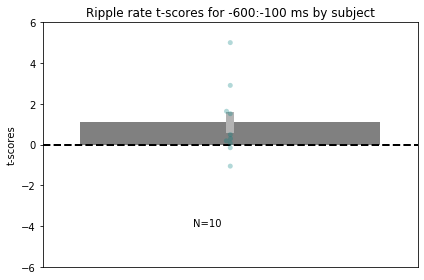

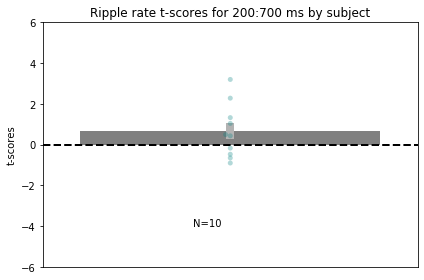

In [267]:
# single comparison plots:

# test 1:
figSub,axSub = plt.subplots(1,1, figsize=(6,4))
test1_tvalues = np.array(test1_tvalues)[~np.isnan(test1_tvalues)]
axSub.bar( 0, np.nanmean(test1_tvalues), yerr = np.nanstd(test1_tvalues)/np.sqrt(len(test1_tvalues)),
          color = (0.5,0.5,0.5), error_kw={'elinewidth':8, 'ecolor':(0.7,0.7,0.7)} )
sb.swarmplot(data=test1_tvalues, ax=axSub, color=(0,0.5,0.5), alpha=0.3)
axSub.plot([axSub.get_xlim()[0],axSub.get_xlim()[1]],[0,0],linewidth=2,linestyle='--',color=(0,0,0),label='_nolegend_')
text(0-0.1,-4,'N='+str(len(test1_tvalues)))
axSub.set(xticks=[])
axSub.set_ylim(-6,6) 
ylabel('t-scores')
title('Ripple rate t-scores for -600:-100 ms by subject')
figSub.tight_layout();

# test 1:
figSub,axSub = plt.subplots(1,1, figsize=(6,4))
test2_tvalues = np.array(test2_tvalues)[~np.isnan(test2_tvalues)]
axSub.bar( 0, np.nanmean(test2_tvalues), yerr = np.nanstd(test2_tvalues)/np.sqrt(len(test2_tvalues)),
          color = (0.5,0.5,0.5), error_kw={'elinewidth':8, 'ecolor':(0.7,0.7,0.7)} )
sb.swarmplot(data=test2_tvalues, ax=axSub, color=(0,0.5,0.5), alpha=0.3)
axSub.plot([axSub.get_xlim()[0],axSub.get_xlim()[1]],[0,0],linewidth=2,linestyle='--',color=(0,0,0),label='_nolegend_')
text(0-0.1,-4,'N='+str(len(test2_tvalues)))
axSub.set(xticks=[])
axSub.set_ylim(-6,6) 
ylabel('t-scores')
title('Ripple rate t-scores for 200:700 ms by subject')
figSub.tight_layout();

In [268]:
test1_tvalues
test2_tvalues

array([ 1.63678641, -0.15270266,  2.90780426, -1.05654109,  1.51766529,
        5.00670316,  0.18577161,  0.2937039 ,  0.49145871,  0.07123431])

array([ 2.28085776,  0.49332851,  1.32418567, -0.47360222, -0.17065162,
        3.1991913 ,  1.04071829, -0.90453403, -0.65436873,  0.43019267])

In [276]:
# ISOLATED RECALLS 
test = 2 # test 1 or test 2? (pre recall bump v. post recall valley)

# test 1 pairwise comparisons by subject:
if test == 1:
    ent_ca1 = [-0.85098251,  1.54166296,  4.63857452, -0.3015888 , -1.26860286,
            0.96750138,  1.94227705,  1.40829184,  1.49079247, -0.55716642,
            1.76256298,  0.34580046,  1.61287741,  2.27550001] 
    ent_dg = [ 0.5513075 ,  1.41499855,  1.56763262,  3.36310246, -0.39345704,
            2.12069449, -0.55947386,  2.07469222,  0.53792351,  1.07474658,
            2.48864782]
    phc_ca1 = [ 0.9227761 ,  0.45469161,  3.55058019,  0.92323064,  2.81916607,
            1.67553711, -0.63377728,  1.3715776 ,  2.71672923, -0.69216144,
            0.22196863,  0.        ,  0.51767695,  0.08305765,  1.84423832,
            0.57804047]
    phc_dg = [ 1.63678641, -0.15270266,  2.90780426, -1.05654109,  1.51766529,
            5.00670316,  0.18577161,  0.2937039 ,  0.49145871,  0.07123431]
    dg_ca1 = [-1.57229228,  0.        ,  0.5662012 ,  0.93370889,  3.996451  ,
            2.05480467,  0.55332263,  0.53129917, -2.56658197,  2.26742746,
            1.12976265,  0.5985056 , -0.61333888,  3.29413508, -2.52580118,
            2.61367083, -1.81275028, -0.63883855,  0.08191849,  4.44774799,
           -0.20899041,  1.44756621,  1.20283353,  0.46837062, -0.51786659,
            0.11687449, -1.74865804,  0.81911242]
    ent_phc = [-1.06789294,  1.90488159, -1.33252431, -0.8112575 , -0.23843643,
            1.61614984,  1.24118203]

# test 2 pairwise comparisons:
if test == 2:
    ent_ca1 = [-1.47821818,  1.21383203,  4.96331649,  7.14628453, -2.82560444,
           -0.76256003,  0.28365431, -1.61677004,  1.42472831,  1.16554303,
           -1.37117396]
    ent_dg = [-5.39687072e-01,  5.66957601e-01,  2.17509216e+00, -8.03405889e-01,
           -2.82348410e+00,  2.46717582e-01,  3.71880921e-01,  8.95995922e-17,
            6.18079665e-01,  1.05654109e+00, -1.16085890e-01]
    phc_ca1 = [ 0.45747373,  1.19145221,  3.98369836,  1.77863836,  0.45174019,
            0.68265615, -2.12462429,  1.31448103,  1.19432621,  1.21762668,
            0.95684317,  0.58172053]
    phc_dg = [ 2.28085776,  0.49332851,  1.32418567, -0.47360222, -0.17065162,
            3.1991913 ,  1.04071829, -0.90453403, -0.65436873,  0.43019267]
    dg_ca1 = [-1.03386828e+00,  1.01904933e+00, -9.87420883e-01,  1.02318563e+00,
            2.28089958e+00,  1.42837966e+00, -1.33598613e+00,  9.17718823e-01,
           -1.25634334e+00,  3.43562832e-01,  1.77975074e+00,  1.07474658e+00,
           -5.51998257e-01,  2.22206728e+00, -1.47797062e+00,  2.22443486e+00,
            0.00000000e+00, -1.96708071e+00,  1.59499294e+00,  1.31003381e+00,
            2.44528099e+00, -1.85077636e+00,  2.31183881e+00,  6.45893114e-01,
            1.60570673e-16, -1.59547039e+00,  7.16705720e-01]
    ent_phc = [-2.59366765,  2.13489435, -0.5744792 ,  0.44973256, -2.2198577 ,
           -0.73379939,  0.67127475]

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


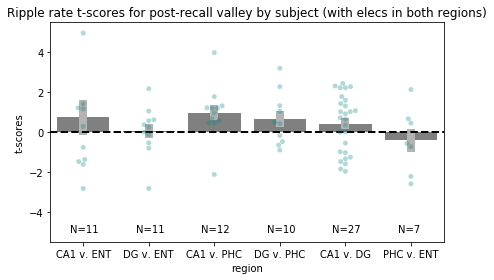

In [277]:
# multiple pairwise comparison plot:
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import fdrcorrection

# make dataframe
comp_data = [ent_ca1,ent_dg,phc_ca1,phc_dg,dg_ca1,ent_phc]
comp_names = ['CA1 v. ENT','DG v. ENT','CA1 v. PHC','DG v. PHC','CA1 v. DG','PHC v. ENT']
col_names = ['region','t-scores']
comp_df = pd.DataFrame(columns=col_names)
for i in range(len(comp_data)):
    temp = pd.DataFrame(columns=col_names)
    temp['t_scores'] = comp_data[i]
    temp['region'] = np.tile(comp_names[i],len(comp_data[i]))
    comp_df = comp_df.append(temp,ignore_index=False)
    
figSub,axSub = plt.subplots(1,1, figsize=(7,4))
axSub.bar( range(len(comp_names)), [np.mean(i) for i in comp_data], 
          yerr = [np.std(i)/np.sqrt(len(i)) for i in comp_data],
          color = (0.5,0.5,0.5), error_kw={'elinewidth':8, 'ecolor':(0.7,0.7,0.7)} )
sb.swarmplot(x='region', y='t_scores', data=comp_df, ax=axSub, color=(0,0.5,0.5), alpha=0.3)
axSub.plot([axSub.get_xlim()[0],axSub.get_xlim()[1]],[0,0],linewidth=2,linestyle='--',color=(0,0,0),label='_nolegend_')
for i in range(len(comp_names)):
    text(i-0.2,-5,'N='+str(len(comp_data[i])))
# put *s for FDR-corrected significance
p_values = []
for i in range(len(comp_data)):
    p_values.append(ttest_1samp(comp_data[i],0)[1])
sig_after_correction = fdrcorrection(p_values)[0]
for i in range(len(sig_after_correction)):
    if sig_after_correction[i]==True:
        text(i-0.02,-4,'*',size=15)

# axSub.set(xticks=[],xticklabels=comp_names)
axSub.set_ylim(-5.5,5.5) 
ylabel('t-scores')
if test == 1:
    title('Ripple rate t-scores for pre-recall bump by subject (with elecs in both regions)')
else:
    title('Ripple rate t-scores for post-recall valley by subject (with elecs in both regions)')
figSub.tight_layout()

save_fig = 1
if save_fig==1:
    savefig('../figures/t_score_comparisons/Test '+str(test)+' pairwise comparison plot')
a=1;

In [272]:
sig_after_correction[1]

False

In [151]:
sb.swarmplot(x="day", y="total_bill", tdata=comp_df, ax=axSub, color=(0,0.5,0.5), alpha=0.3)

ValueError: Could not interpret input 'day'